Aline Freire de Rezende<br>116110571

# Python imports

In [1]:
import numpy as np
import scipy as sp
from google.colab.patches import cv2_imshow
from google.colab import files
from matplotlib import patheffects
import matplotlib.pyplot as plt
import json


## JSON upload

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  f = open(fn, )
  graphic_data = json.load(f)
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving circle.json to circle (6).json
User uploaded file "circle.json" with length 204 bytes


# Code (inside test and Screen class)

In [3]:
graphic_data

{'height': 220,
 'scene': [{'center': [100, 100],
   'color': [0, 0, 250],
   'radius': 80,
   'shape': 'circle'}],
 'width': 320}

In [4]:
def inside(x, y, primitive):
  """
  Check if point (x,y) is inside the primitive
  
  Args:
    x (float): horizontal point position
    y (float): vertical point position
  Returns:
    True if (x,y) is inside the primitive, False case contrary
  """
  
  # You should implement your inside test here for all shapes   
  # for now, it only returns a false test

  # To do (triângulo, círculo, polígono convexo) - primeiro parágrafo que tem coisa pra fazer
  # {'shape': 'polygon', 'vertices': [[50, 25], [300, 25], [300, 140], [160, 180]], 'color': [121, 67, 91], 'xform': [[0.5, 0, 15], [0, 0.75, 20], [0, 0, 1]]}

  if (primitive["shape"] == "triangle"):
    if (insideTriangle(x, y, primitive["vertices"]) == True):
      return True
    return False

  if (primitive["shape"] == "circle"):
    for triangle in primitive["triangulation"]:
      if (insideTriangle(x, y, triangle) == True):
        return True

  return False

In [5]:
def circleTriangulation(circle): # centro, raio * cosseno, raio * seno
  triangles = []
  points = []
  slices = 12

  for i in range(slices):
    # somei ao centro pois o círculo não está necessariamente centrado na origem
    x = circle["center"][0] + (circle["radius"] * np.cos(2 * np.pi * i / 60))
    y = circle["center"][1] + (circle["radius"] * np.sin(2 * np.pi * i / 60)) 
    point = [x, y]
    points.append(point)

  for i in range(slices):
    A = circle["center"].copy()
    B = points[i].copy()
    C = points[(i+1)%slices].copy() 
    triangles.append([A, B, C])

  return triangles

In [6]:
def buildsVector(pointA, pointB): # AB = B - A
  vector = np.zeros(2, int)

  iA = pointA[0]
  jA = pointA[1]
  iB = pointB[0]
  jB = pointB[1]

  vector[0] = iB-iA
  vector[1] = jB-jA

  return vector

In [7]:
def findNormal(vector): # é basicamente uma rotação anti-horária
  normal = np.zeros(2, int)
  
  i = vector[0]
  j = vector[1]

  normal[0] = -j
  normal[1] = i

  return normal

In [8]:
def insideTriangle(x, y, triangle): # para rotação no sentido anti-horário

  #inicialização de variáveis
  AB = BC = CA = np.zeros(2, int)
  Ap = Bp = Cp = np.zeros(2, int)
  nAB = nBC = nCA = np.zeros(2, int)
  alfaAB = alfaBC = alfaCA = 0
  
  # Ajustando os vértices e o ponto
  A = triangle[0]
  B = triangle[1]
  C = triangle[2]
  p = np.array([x,y])

  # Construindo os vetores do triângulo
  AB = buildsVector(A, B)
  BC = buildsVector(B, C)
  CA = buildsVector(C, A)
    
  # Construindo os vetores de cada vértice ao ponto
  Ap = buildsVector(A, p)
  Bp = buildsVector(B, p)
  Cp = buildsVector(C, p)

  # Encontrando as normais (para dentro) aos vetores do triângulo
  nAB = findNormal(AB)
  nBC = findNormal(BC)
  nCA = findNormal(CA)

  # Produto interno das normais de cada vetor do triângulo com os vetores dos vértices aos pontos
  alfaAB = nAB @ Ap
  alfaBC = nBC @ Bp
  alfaCA = nCA @ Cp

  # Se todos os alfas forem positivos, sinal de que o ângulo é agudo e o ponto está dentro do triângulo
  if (alfaAB >= 0 and alfaBC >= 0 and alfaCA >= 0):
    return True
  return False

In [9]:
triangulo = np.array([[10,30], [60,100], [50,10]])
insideTriangle(40,60.5,triangulo)

False

In [10]:
class Screen:
  ''' Creates a virtual basic screen

    Args:
        gdata (dict): dictionary containing screen size and scene description
    '''

  def __init__(self, gdata):
    self._width = gdata.get("width")
    self._height = gdata.get("height")
    self._scene = self.preprocess( gdata.get("scene") )
    self.create_image()


  def preprocess(self, scene):
    ''' ?????????????

    Args:
      scene (dict): Scene containing the graphic primitives

    Returns:
      scene (dict): Scene containing the graphic primitives with additional info
    '''

    # To do bounding box - segundo parágrafo que tem coisa pra fazer



    # To do (triangularização do círculo


    # Possible preprocessing with scene primitives, for now we don't change anything
    # You may define bounding boxes, convert shapes, etc
    preprop_scene = []

    for primitive in scene:
      # do some processing
      # for now, only copies each primitive to a new list

      if (primitive["shape"] == "circle"):
        triangles = circleTriangulation(primitive)
        primitive["triangulation"] = triangles
      
      preprop_scene.append(primitive)

    return preprop_scene

  def create_image(self):
    ''' Creates image with white background 
    
    Returns 
      image (numpy array): White image with R, G, B channels
    '''

    self._image = 255 *  np.ones((self._height, self._width, 3), np.uint8)

  def rasterize(self):
    ''' Rasterize the primitives along the Screen    
    '''
    
    for primitive in self._scene:
    # Loop through all pixels
    # You MUST use bounding boxes in order to speed up this loop
      for w in range(0, self._width):
        x = w + 0.5
        for h in range(0, self._height):
          y = h + 0.5
          # First, we check if the pixel center is inside the primitive
          if ( inside(x, y, primitive) ):
            im_x, im_y = w, self._height - (h + 1)
            self._image[im_y, im_x] = primitive['color'][::-1]
        

  def show(self, exec_rasterize = False):
    ''' Show the virtual Screen    
    '''

    if (exec_rasterize):
      self.rasterize()
      
    cv2_imshow(self._image)

  

# Virtual Screen 

### Initialization

In [11]:
screen = Screen(graphic_data)

### Rasterization and raster graphic visualization

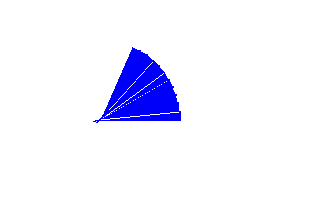

In [12]:
screen.show(True)